include references???

add doc strings???

3 main packages were used here: custom build CLEASE, Python-LAMMPS, CHGNet

CLEASE is easy to install, just clone the repo and do `pip install .`

CHGNet can be installed with `pip install chgnet`, but it is preferable to be run on GPU

LAMMPS need to be complied with python interface and couple other packages enabled, and will take quite some time.

In [1]:
import sys
sys.path.append("/nfs/turbo/coe-venkvis/ziqiw-turbo/PD/solid/clease")

import json
import logging
import sys, os, time
import yaml
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# from lammps import lammps

from ase.db import connect
from ase.calculators.emt import EMT
from ase.calculators.eam import EAM
from ase.calculators.lammpslib import LAMMPSlib
from ase.visualize import view
from ase import Atom, Atoms
from ase.build import bulk
from ase.data import atomic_numbers
from ase.io.trajectory import TrajectoryWriter
from ase.io import write, read
from ase.units import kB
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter

import nglview as nv

from clease.settings import Concentration
from clease.structgen import NewStructures
from clease.settings import CEBulk
from clease.calculator import attach_calculator
from clease.montecarlo import Montecarlo, constraints, SGCMonteCarlo, BinnedBiasPotential, MetaDynamicsSampler
from clease.montecarlo.observers import ConcentrationObserver, MoveObserver, CorrelationFunctionObserver
from clease.tools import update_db
from clease import Evaluate
import clease.plot_post_process as pp

from chgnet.model.model import CHGNet
from chgnet.model.dynamics import MolecularDynamics, StructOptimizer, CHGNetCalculator
from pymatgen.core import Structure

# from drawpd import LTE, MF

First load all options from the yaml file

DEBUG is a parameter use to print varies level of information (not useful in this demo)

Then load LAMMPS calculator if it's specified in the yaml file

`GroundStates` was later to be iterate through

`gs_db_names` indicate which file to load for the ground state structure

Then load `muInit` and `muFinal` that will be sweeped with increment of `dMu`

Then it is to figure out the sign of `dMu` since when specifying it, we are specifying the absolute dµ

In [170]:
np.set_printoptions(precision=3, suppress=True)

with open('LiNa-example.yaml', 'r') as file:
    options = yaml.safe_load(file)

DEBUG = options["EMC"]["DEBUG"]

if "LAMMPS" in options:
        from ase.calculators.lammpslib import LAMMPSlib
        print("LAMMPS calc!")
        ASElammps = LAMMPSlib(**options["LAMMPS"])

GroundStates = options["GroundStates"]
gs_db_names = options["EMC"]["gs_db_names"]
muInit, muFinal = options["EMC"]["muInit"], options["EMC"]["muFinal"]
dMu = options["EMC"]["dMu"]

dMu = abs(dMu)
if (muFinal - muInit)*dMu < 0:
    dMu = -dMu

LAMMPS calc!


In [154]:
GroundStates

['Li', 'Na']

Here are the two end points we are going to start with

In [26]:
for gsIdx, gs_name in enumerate(GroundStates):
    db = connect(gs_db_names[gsIdx])
    gs05 = None
    for row in db.select(""):
        gs05 = row.toatoms()
        view(gs05)

mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


## Fitting Cluster exapnsion model

This is to specify which groud state we are currently trying to fit a cluster expansion model to

In [3]:
workingOnGS = 0

Utility functions

In [4]:
import re, numpy
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter, ExpCellFilter, StrainFilter

def get_conc(atoms):
    return np.sum(atoms.numbers == 3) / len(atoms)

def get_conc_from_formula(formula):
    GroundStates = options["GroundStates"]
    myKey = options["CLEASE"][GroundStates[workingOnGS]]["CESettings"]["concentration"][0][0] + '|' +  options["CLEASE"][GroundStates[workingOnGS]]["CESettings"]["concentration"][0][1]
    sperated = re.split(myKey, formula)
    for i in range(len(sperated)):
        if sperated[i] == '':
            sperated[i] = '1'
    if len(sperated) == 3:
        return int(sperated[1])/(int(sperated[2]) + int(sperated[1]))
    elif len(sperated) == 2:
        if formula[:2] == options["CLEASE"][GroundStates[workingOnGS]]["CESettings"]["concentration"][0][0]:
            return 1
        elif formula[:2] == options["CLEASE"][GroundStates[workingOnGS]]["CESettings"]["concentration"][0][1]:
            return 0
    return numpy.inf

def calculate_energies(db_name, myCalc, DEBUG = 0):
    db = connect(db_name)

    # finalScale = np.array(finalScale)
    # finalX = np.array(finalX)
    Xs = []
    Ss = []

    for row in db.select(converged=False):
        fomula = row.formula
        x = get_conc_from_formula(fomula)
        atoms = row.toatoms()
        atomsInit = atoms.copy()
        oldV = atoms.cell.volume
        atoms.calc = myCalc

        ucf = UnitCellFilter(atoms)
        opt = BFGS(ucf)
        opt.run(fmax=0.02)
        atoms.get_potential_energy()
        
        finalScale = atoms.cell.volume/oldV
        print("at x =", x, "scale =", finalScale)
        Xs.append(x)
        Ss.append(finalScale)

        update_db(uid_initial=row.id, final_struct=atoms, db_name=db_name)
    return Xs, Ss

def get_num(input_string, A, B):
        elements = re.findall(A+'|'+B+'|\d+', input_string)
        separated_array = []

        for element in elements:
            if element.isdigit():
                separated_array.append(int(element))
            else:
                separated_array.append(element)
            
        ACount = 0
        BCount = 0
        
        for idx, i in enumerate(separated_array):
            if i == A:
                ACount += 1
            elif i == B:
                BCount += 1
            elif isinstance(i, int):
                if separated_array[idx-1] == A:
                    ACount += i-1
                elif separated_array[idx-1] == B:
                    BCount += i-1
    
        return [ACount, BCount]

again `GroundStates` was later to be iterate through

`gs_names` indicate which ground state

`db_name` indicates the .db file that contains the ground state strucutre

`conc` is the CLEASE required way of specifying the basis of the system

`hhsettings` will be used to fit the cluster expansion model


In [5]:
GroundStates = options["GroundStates"]
gs_name = GroundStates[workingOnGS]
db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])
tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
tmp['concentration'] = conc
hhsettings = CEBulk(**tmp)

## starting from scratch


In [6]:
genNum = 40

In [33]:
template = hhsettings.prim_cell.copy()

template *= (4,4,4)

numberOfConc = 10
for i in range(numberOfConc):
    ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
    # ns.generate_random_structures(atoms=template, conc=np.array([i/(numberOfConc-1), 1-i/(numberOfConc-1)]))
    ns.generate_random_structures(atoms=template, conc=np.array([(i/(numberOfConc-1))*0.6+0.2, (1-i/(numberOfConc-1))*0.6+0.2]))
    # ns.generate_random_structures(atoms=template, conc=np.array([0.3,0.7]))

    genNum += 1

In [34]:
ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=20)
ns.generate_probe_structure()
genNum += 1

      Step     Time          Energy          fmax
BFGS:    0 15:48:44      -63.410532        1.707585
BFGS:    1 15:48:44      -63.608439        1.695624
BFGS:    2 15:48:44      -64.985252        1.605181
BFGS:    3 15:48:44      -66.012904        1.531346
BFGS:    4 15:48:44      -66.775168        1.466653
BFGS:    5 15:48:44      -67.351245        1.408140
BFGS:    6 15:48:44      -67.813693        1.353344
BFGS:    7 15:48:44      -68.222993        1.300141
BFGS:    8 15:48:44      -68.620950        1.247023
BFGS:    9 15:48:44      -69.029981        1.193199
BFGS:   10 15:48:44      -69.458751        1.138688
BFGS:   11 15:48:44      -69.908401        1.083467
BFGS:   12 15:48:44      -70.376032        1.040332
BFGS:   13 15:48:44      -70.857383        1.018280
BFGS:   14 15:48:44      -71.347307        0.984417


/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_78620/4058431899.py:40: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms)


BFGS:   15 15:48:44      -71.840541        0.940957
BFGS:   16 15:48:45      -72.332039        0.891782
BFGS:   17 15:48:45      -72.817151        0.838027
BFGS:   18 15:48:45      -73.291546        0.780842
BFGS:   19 15:48:45      -73.751652        0.728073
BFGS:   20 15:48:45      -74.194559        0.681463
BFGS:   21 15:48:45      -74.617527        0.632280
BFGS:   22 15:48:45      -75.018266        0.599355
BFGS:   23 15:48:45      -75.395136        0.587486
BFGS:   24 15:48:45      -75.746481        0.575726
BFGS:   25 15:48:45      -76.070891        0.561839
BFGS:   26 15:48:45      -76.367095        0.545436
BFGS:   27 15:48:45      -76.634282        0.525986
BFGS:   28 15:48:45      -76.871449        0.502824
BFGS:   29 15:48:45      -77.077829        0.475010
BFGS:   30 15:48:45      -77.252959        0.442449
BFGS:   31 15:48:45      -77.396467        0.400188
BFGS:   32 15:48:45      -77.509014        0.344375
BFGS:   33 15:48:45      -77.590056        0.293125
BFGS:   34 1

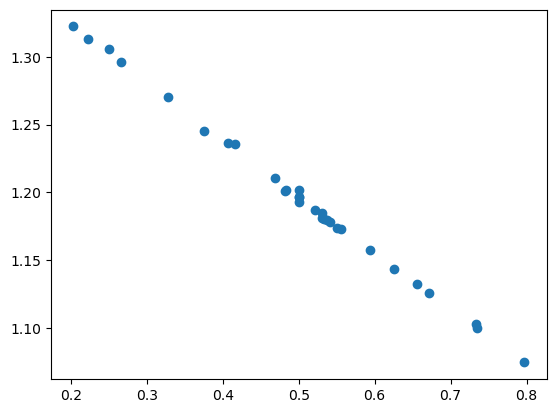

In [10]:
Xs, Ss = calculate_energies(db_name, ASElammps, DEBUG=1)
plt.plot(Xs, Ss, 'o')

In [10]:
db = connect(db_name)
eciName = options["CLEASE"][gs_name]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    with open(db_name + "-eci.json") as f:
        eci = json.load(f)
else:
    with open(eciName) as f:
        eci = json.load(f)
iii = 0
skipped = 0
for row in db.select('struct_type=initial'):
    print("woring on:", iii)
    template = row.toatoms()
    try:
        ns = NewStructures(hhsettings, generation_number=genNum, struct_per_gen=1)
        ns.generate_gs_structure(atoms=template, init_temp=1e3,
                                    final_temp=1, num_temp=200,
                                    num_steps_per_temp=5000,
                                    eci=eci, random_composition=True)
        genNum += 1
    except:
        skipped += 1
        print(skipped, "structure skipped")
    iii += 1

woring on: 0
woring on: 1
woring on: 2
woring on: 3
woring on: 4
woring on: 5
woring on: 6
woring on: 7
woring on: 8
woring on: 9
woring on: 10
woring on: 11
woring on: 12
woring on: 13
1 structure skipped
woring on: 14
woring on: 15
woring on: 16
woring on: 17
woring on: 18
woring on: 19
woring on: 20
woring on: 21
woring on: 22
2 structure skipped
woring on: 23
3 structure skipped
woring on: 24
woring on: 25
woring on: 26
woring on: 27
woring on: 28
woring on: 29


## starting from existing dataset

This is to load structures from DFT calculation

failed ones are when CLEASE fail to create a template for it due to PBC

In [87]:
trajAtoms = read("/Users/Michael_wang/Documents/venkat/artemis-PD/PD/LiMg/LiMg-July4-7-hcp.traj", index=':')

for idx, atoms in enumerate(trajAtoms):
    try:
        print(f"adding {idx}")
        ns = NewStructures(hhsettings, generation_number=1, struct_per_gen=1)
        ns.insert_structure(init_struct=atoms)
    except:
        print(f"{idx} failed")

adding 0
adding 1
adding 2
2 failed
adding 3
adding 4


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 5
5 failed
adding 6


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 7
adding 8
adding 9
adding 10
10 failed
adding 11
11 failed
adding 12
adding 13


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 14
adding 15
adding 16
adding 17
adding 18
adding 19
19 failed
adding 20
adding 21


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 22
adding 23
23 failed
adding 24


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 25
25 failed
adding 26
26 failed
adding 27
adding 28


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 29
29 failed
adding 30


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 31
adding 32
32 failed
adding 33


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 34
34 failed
adding 35
adding 36


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


36 failed
adding 37
37 failed
adding 38
38 failed
adding 39
adding 40


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 41
adding 42
adding 43
43 failed
adding 44
44 failed
adding 45
adding 46


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 47
adding 48
adding 49
adding 50
adding 51
adding 52
52 failed
adding 53


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 54
adding 55
adding 56
adding 57
57 failed
adding 58
58 failed
adding 59
adding 60


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 61
61 failed
adding 62
62 failed
adding 63
63 failed
adding 64
64 failed
adding 65


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 66
66 failed
adding 67


mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle
mach_inject_bundle load_bundle_package: /Library/Application Support/MacEnhance/Plugins/AfloatX.bundle


adding 68
adding 69
adding 70
adding 71
adding 72


This is to relax the cell, calculate the energy, and update the .db file for later CE fitting

      Step     Time          Energy          fmax
BFGS:    0 16:30:34      -56.499278        1.973886
BFGS:    1 16:30:34      -56.718470        1.960435
BFGS:    2 16:30:34      -58.135935        1.868454
BFGS:    3 16:30:34      -59.350583        1.785490
BFGS:    4 16:30:34      -60.392145        1.709543
BFGS:    5 16:30:34      -61.287849        1.639047
BFGS:    6 16:30:34      -62.064330        1.571679
BFGS:    7 16:30:34      -62.745908        1.508808
BFGS:    8 16:30:34      -63.354746        1.448483
BFGS:    9 16:30:34      -63.911023        1.390145
BFGS:   10 16:30:34      -64.431584        1.333232
BFGS:   11 16:30:34      -64.929527        1.363341
BFGS:   12 16:30:34      -65.413688        1.453003
BFGS:   13 16:30:34      -65.890257        1.513143
BFGS:   14 16:30:34      -66.362595        1.545765
BFGS:   15 16:30:34      -66.832286        1.553693


/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_81134/4058431899.py:40: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms)


BFGS:   16 16:30:34      -67.299669        1.540120
BFGS:   17 16:30:34      -67.764272        1.508319
BFGS:   18 16:30:34      -68.225132        1.461443
BFGS:   19 16:30:34      -68.681076        1.402410
BFGS:   20 16:30:34      -69.130987        1.333864
BFGS:   21 16:30:34      -69.573086        1.258074
BFGS:   22 16:30:34      -70.006055        1.183447
BFGS:   23 16:30:34      -70.429129        1.097323
BFGS:   24 16:30:34      -70.841032        1.009337
BFGS:   25 16:30:34      -71.240290        0.920242
BFGS:   26 16:30:34      -71.625110        0.870601
BFGS:   27 16:30:34      -71.995005        0.828146
BFGS:   28 16:30:34      -72.348327        0.782138
BFGS:   29 16:30:34      -72.684129        0.732758
BFGS:   30 16:30:34      -73.001215        0.680172
BFGS:   31 16:30:34      -73.298854        0.624311
BFGS:   32 16:30:34      -73.575977        0.565071
BFGS:   33 16:30:34      -73.831384        0.502177
BFGS:   34 16:30:34      -74.063658        0.435106
BFGS:   35 1

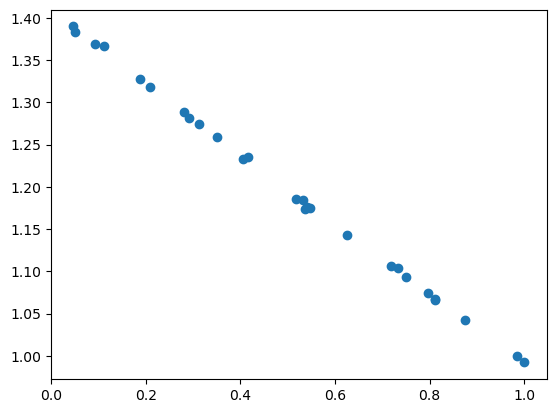

In [11]:
Xs, Ss = calculate_energies(db_name, ASElammps)
plt.plot(Xs, Ss, 'o')

why there outliers???

Fitting the CE model

/var/folders/k_/jq6m6ps14v59j7zn4tqygzjr0000gn/T/ipykernel_81134/1585318581.py:8: DeprecationWarning: Call to deprecated method plot_CV. (Use the alpha_CV method instead.) -- Deprecated since version 0.11.7.
  alpha = eva.plot_CV(**CEFittingOptions["regularization"])


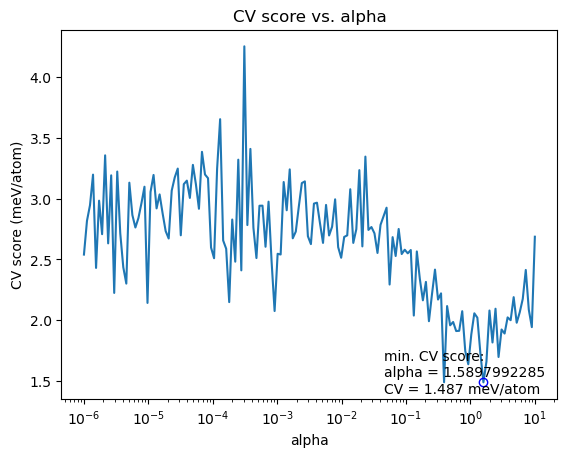

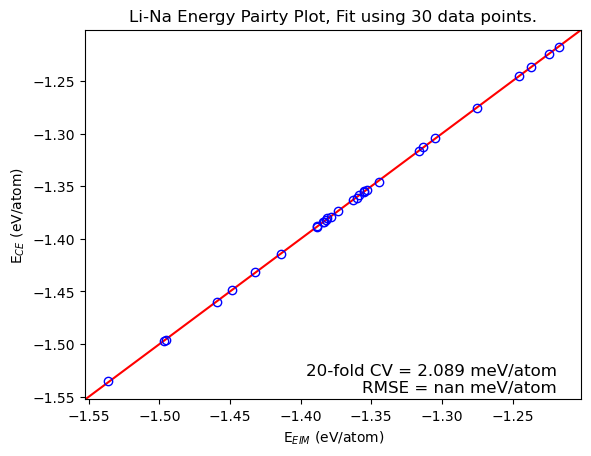

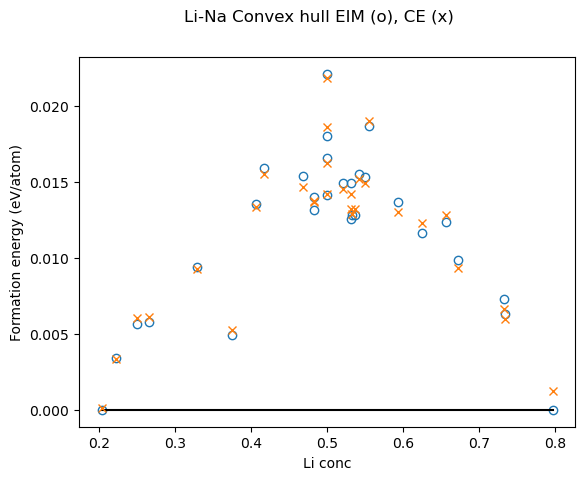

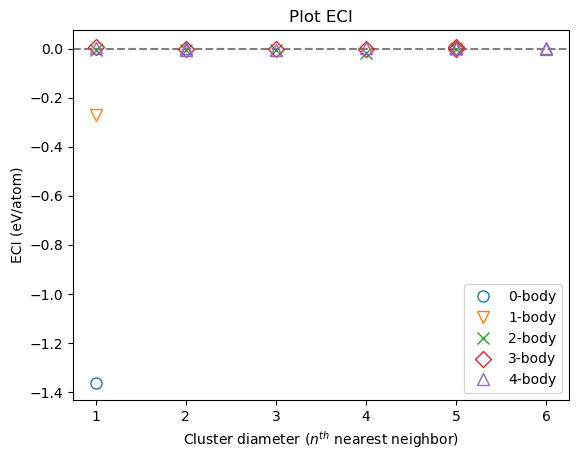

In [58]:
%matplotlib inline
with open('LiNa-example.yaml', 'r') as file:
    options = yaml.safe_load(file)
CEFittingOptions = options["CLEASE"][GroundStates[workingOnGS]]["CEFitting"]
eva = Evaluate(settings=hhsettings, scoring_scheme=CEFittingOptions["scoring_scheme"], nsplits=CEFittingOptions["nsplits"])
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"])

alpha = eva.plot_CV(**CEFittingOptions["regularization"])

# set the alpha value with the one found above, and fit data using it.
eva.set_fitting_scheme(fitting_scheme=CEFittingOptions["fitting_scheme"], alpha=alpha)
eva.fit()  # Run the fit with these settings.

fig = pp.plot_fit(eva)
plt.show()


fig = pp.plot_convex_hull(eva)
plt.show()


# plot ECI values
fig = pp.plot_eci(eva)
plt.show()

plot one w/o 0 body???

This is just to plot all energies out

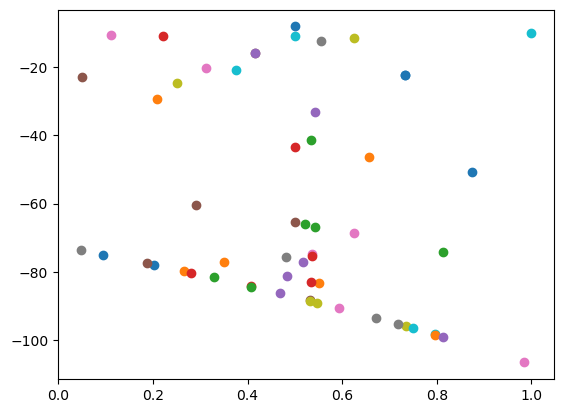

In [15]:
tmp = connect(db_name)
plt.figure()
for i in tmp.select("struct_type=final"):
    atoms = i.toatoms()
    tmpConc = np.sum(atoms.numbers == 3)/len(atoms.numbers)
    # print(tmpConc, atoms.get_potential_energy())
    plt.plot(tmpConc, atoms.get_potential_energy(), 'o')
plt.show()

save the ECIs fitted

In [16]:
eciName = options["CLEASE"][GroundStates[workingOnGS]]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    eciName = db_name + "-eci.json"
eva.save_eci(fname=eciName)

## Different Energies
Formation energies with BCC Li and HCP Mg as reference using relaxed ECIs

failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc
failed attach CLEASE calc


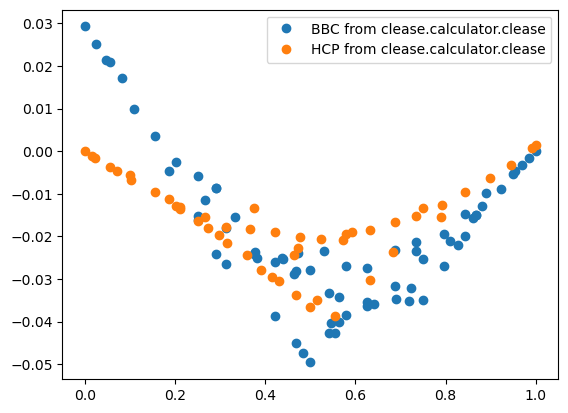

In [6]:


# chgnet = CHGNet.load()
# calc = CHGNetCalculator(model=chgnet)
# calc = ASElammps
# calc = None #if calc == None, use calc that come with the atoms object

calcList = ["CLEASE"]
symbolList = ['o', '^', 's']

for calcIdx, calc in enumerate(calcList):
    bccDB = connect("LiMg/LiMg-July4-8-bcc-DFT.db")
    
    gs_name = GroundStates[0]
    db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
    conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])

    tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
    tmp['concentration'] = conc
    MCsettings = CEBulk(**tmp)

    eciName = options["CLEASE"][gs_name]["CEFitting"]["ECI_filename"]
    if eciName == "FROM DB":
        with open(db_name + "-eci.json") as f:
            eci = json.load(f)
    else:
        with open(eciName) as f:
            eci = json.load(f)

    if os.path.isfile("bccE.npy"):
        bccE = np.load("bccE.npy", allow_pickle=True)
        bccX = np.load("bccX.npy", allow_pickle=True)
        bccN = np.load("bccN.npy", allow_pickle=True)
    else:
        bccE = []
        bccX = []
        bccN = []
        for idx, bcc in enumerate(bccDB.select("")):
            bccAtoms = bcc.toatoms()

            if len(bccAtoms) == 1:
                continue
            
            try:
                if calc:
                    if calc == "CLEASE":
                        bccAtoms = attach_calculator(MCsettings, atoms=bccAtoms, eci=eci)
                    else:
                        bccAtoms.calc = calc
                if np.sum(bccAtoms.numbers == 3) <= len(bccAtoms):
                    # bccXTmp = np.sum(bccAtoms.numbers == 3)/(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                    bccXTmp = np.sum(bccAtoms.numbers == 3)/len(bccAtoms)
                    bccX.append(bccXTmp)
                    bccE.append(bccAtoms.get_potential_energy())
                    # bccN.append(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                    bccN.append(len(bccAtoms))
                    # print(idx, bccX[-1], bccE[-1])
                if len(bccAtoms) == np.sum(bccAtoms.numbers == 3):
                    bccLiGS = bccAtoms.get_potential_energy()/len(bccAtoms)
                if np.sum(bccAtoms.numbers == 3) == 0:
                    bccMgGS = bccAtoms.get_potential_energy()/len(bccAtoms)
            except:
                print(f"failed attach CLEASE calc")


        bccE = np.array(bccE)
        bccX = np.array(bccX)
        bccN = np.array(bccN)

        # np.save("bccE.npy", bccE)
        # np.save("bccX.npy", bccX)
        # np.save("bccN.npy", bccN)
        

    bccEPA = bccE/bccN


    hcpDB = connect("LiMg/LiMg-July4-7-hcp-DFT.db")
    
    gs_name = GroundStates[1]
    db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
    conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])

    tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
    tmp['concentration'] = conc
    MCsettings = CEBulk(**tmp)

    eciName = options["CLEASE"][gs_name]["CEFitting"]["ECI_filename"]
    if eciName == "FROM DB":
        with open(db_name + "-eci.json") as f:
            eci = json.load(f)
    else:
        with open(eciName) as f:
            eci = json.load(f)

    if os.path.isfile("hcpE.npy"):
        hcpE = np.load("hcpE.npy", allow_pickle=True)
        hcpX = np.load("hcpX.npy", allow_pickle=True)
        hcpN = np.load("hcpN.npy", allow_pickle=True)
    else:
        hcpE = []
        hcpX = []
        hcpN = []
        for idx, hcp in enumerate(hcpDB.select("")):
            hcpAtoms = hcp.toatoms()
            
            if len(hcpAtoms) == 1:
                continue
            try:
                if calc:
                    if calc == "CLEASE":
                        hcpAtoms = attach_calculator(MCsettings, atoms=hcpAtoms, eci=eci)
                    else:
                        hcpAtoms.calc = calc
                if np.sum(hcpAtoms.numbers == 3) <= len(hcpAtoms):
                    # hcpXTmp = np.sum(hcpAtoms.numbers == 3)/(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                    hcpXTmp = np.sum(hcpAtoms.numbers == 3)/len(hcpAtoms)
                    hcpX.append(hcpXTmp)
                    hcpE.append(hcpAtoms.get_potential_energy())
                    # hcpN.append(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                    hcpN.append(len(hcpAtoms))
                    # print(idx, hcpX[-1], hcpE[-1])
                if np.sum(hcpAtoms.numbers == 3) == 0:
                    hcpMgGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)
                if np.sum(hcpAtoms.numbers == 3) == len(hcpAtoms):
                    hcpLiGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)
            except:
                print(f"failed attach CLEASE calc")

        hcpE = np.array(hcpE)
        hcpX = np.array(hcpX)
        hcpN = np.array(hcpN)

        # np.save("hcpE.npy", hcpE)
        # np.save("hcpX.npy", hcpX)
        # np.save("hcpN.npy", hcpN)
        
    hcpEPA = hcpE/hcpN
    # hcpGS = bccEPA[bccX == 0][0]
    # bccGS = hcpEPA[hcpX == 1][0]

    bccFormationEPA = bccEPA -  (1-bccX) * hcpMgGS - bccX * bccLiGS
    hcpFormationEPA = hcpEPA -  (1-hcpX) * hcpMgGS - hcpX * bccLiGS

    # print("bcc li:", bccGS, "hcp li:", hcpEPA[hcpX == 1][0])
    # print("bcc mg:", bccEPA[bccX == 0][0], "hcp mg:", hcpGS)
    # print("bccGS", bccGS, "hcpGS", hcpGS)

    plt.plot(bccX, bccFormationEPA, symbolList[calcIdx], c="tab:blue", label=f"BBC from {hcpAtoms.calc.__module__}")
    plt.plot(hcpX, hcpFormationEPA, symbolList[calcIdx], c="tab:orange", label=f"HCP from {hcpAtoms.calc.__module__}")
# plt.xlim([0, 1])
# plt.ylim([np.min(bccFormationEPA[bccX <= 1]), np.max(bccFormationEPA[bccX <= 1])])
# plt.legend(["bcc", "hcp"])
# plt.title("HCP LiMg")
# plt.savefig("convex_hull.png")
plt.legend()
plt.show()

non-relaxed formation energies. with BCC Li and HCP Mg as reference

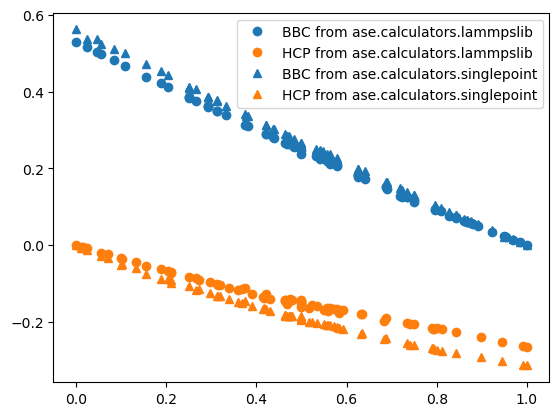

In [33]:
# chgnet = CHGNet.load()
# calc = CHGNetCalculator(model=chgnet)
# calc = ASElammps
# calc = None #if calc == None, use calc that come with the atoms object

calcList = [ASElammps, None]
symbolList = ['o', '^']

for calcIdx, calc in enumerate(calcList):
    bccDB = connect("LiMg/LiMg-July4-8-bcc-DFT.db")

    if os.path.isfile("bccE.npy"):
        bccE = np.load("bccE.npy", allow_pickle=True)
        bccX = np.load("bccX.npy", allow_pickle=True)
        bccN = np.load("bccN.npy", allow_pickle=True)
    else:
        bccE = []
        bccX = []
        bccN = []
        for idx, bcc in enumerate(bccDB.select("")):
            bccAtoms = bcc.toatoms()

            if len(bccAtoms) == 1:
                continue

            if calc:
                bccAtoms.calc = calc
            if np.sum(bccAtoms.numbers == 3) <= len(bccAtoms):
                # bccXTmp = np.sum(bccAtoms.numbers == 3)/(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                bccXTmp = np.sum(bccAtoms.numbers == 3)/len(bccAtoms)
                bccX.append(bccXTmp)
                bccE.append(bccAtoms.get_potential_energy())
                # bccN.append(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                bccN.append(len(bccAtoms))
                # print(idx, bccX[-1], bccE[-1])
            if len(bccAtoms) == np.sum(bccAtoms.numbers == 3):
                bccLiGS = bccAtoms.get_potential_energy()/len(bccAtoms)
            if np.sum(bccAtoms.numbers == 3) == 0:
                bccMgGS = bccAtoms.get_potential_energy()/len(bccAtoms)


        bccE = np.array(bccE)
        bccX = np.array(bccX)
        bccN = np.array(bccN)

        # np.save("bccE.npy", bccE)
        # np.save("bccX.npy", bccX)
        # np.save("bccN.npy", bccN)
        

    bccEPA = bccE/bccN


    hcpDB = connect("LiMg/LiMg-July4-7-hcp-DFT.db")

    if os.path.isfile("hcpE.npy"):
        hcpE = np.load("hcpE.npy", allow_pickle=True)
        hcpX = np.load("hcpX.npy", allow_pickle=True)
        hcpN = np.load("hcpN.npy", allow_pickle=True)
    else:
        hcpE = []
        hcpX = []
        hcpN = []
        for idx, hcp in enumerate(hcpDB.select("")):
            hcpAtoms = hcp.toatoms()
            
            if len(hcpAtoms) == 1:
                continue
            
            if calc:
                hcpAtoms.calc = calc
            if np.sum(hcpAtoms.numbers == 3) <= len(hcpAtoms):
                # hcpXTmp = np.sum(hcpAtoms.numbers == 3)/(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                hcpXTmp = np.sum(hcpAtoms.numbers == 3)/len(hcpAtoms)
                hcpX.append(hcpXTmp)
                hcpE.append(hcpAtoms.get_potential_energy())
                # hcpN.append(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                hcpN.append(len(hcpAtoms))
                # print(idx, hcpX[-1], hcpE[-1])
            if np.sum(hcpAtoms.numbers == 3) == 0:
                hcpMgGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)
            if np.sum(hcpAtoms.numbers == 3) == len(hcpAtoms):
                hcpLiGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)

        hcpE = np.array(hcpE)
        hcpX = np.array(hcpX)
        hcpN = np.array(hcpN)

        # np.save("hcpE.npy", hcpE)
        # np.save("hcpX.npy", hcpX)
        # np.save("hcpN.npy", hcpN)
        
    hcpEPA = hcpE/hcpN
    # hcpGS = bccEPA[bccX == 0][0]
    # bccGS = hcpEPA[hcpX == 1][0]

    bccFormationEPA = bccEPA -  (1-bccX) * hcpMgGS - bccX * bccLiGS
    hcpFormationEPA = hcpEPA -  (1-hcpX) * hcpMgGS - hcpX * bccLiGS

    # print("bcc li:", bccGS, "hcp li:", hcpEPA[hcpX == 1][0])
    # print("bcc mg:", bccEPA[bccX == 0][0], "hcp mg:", hcpGS)
    # print("bccGS", bccGS, "hcpGS", hcpGS)

    plt.plot(bccX, bccFormationEPA, symbolList[calcIdx], c="tab:blue", label=f"BBC from {hcpAtoms.calc.__module__}")
    plt.plot(hcpX, hcpFormationEPA, symbolList[calcIdx], c="tab:orange", label=f"HCP from {hcpAtoms.calc.__module__}")
# plt.xlim([0, 1])
# plt.ylim([np.min(bccFormationEPA[bccX <= 1]), np.max(bccFormationEPA[bccX <= 1])])
# plt.legend(["bcc", "hcp"])
# plt.title("HCP LiMg")
# plt.savefig("convex_hull.png")
plt.legend()
plt.show()

Formation energies with BCC Li and BCC Mg as reference for BCC systems, and HCP Li and HCP Mg for HCP systems

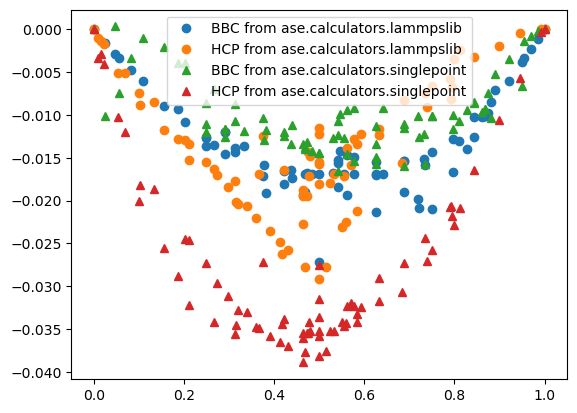

In [34]:
# chgnet = CHGNet.load()
# calc = CHGNetCalculator(model=chgnet)
# calc = ASElammps
# calc = None #if calc == None, use calc that come with the atoms object

calcList = [ASElammps, None]
symbolList = ['o', '^']

for calcIdx, calc in enumerate(calcList):
    bccDB = connect("LiMg/LiMg-July4-8-bcc-DFT.db")

    if os.path.isfile("bccE.npy"):
        bccE = np.load("bccE.npy", allow_pickle=True)
        bccX = np.load("bccX.npy", allow_pickle=True)
        bccN = np.load("bccN.npy", allow_pickle=True)
    else:
        bccE = []
        bccX = []
        bccN = []
        for idx, bcc in enumerate(bccDB.select("")):
            bccAtoms = bcc.toatoms()

            if len(bccAtoms) == 1:
                continue

            if calc:
                bccAtoms.calc = calc
            if np.sum(bccAtoms.numbers == 3) <= len(bccAtoms):
                # bccXTmp = np.sum(bccAtoms.numbers == 3)/(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                bccXTmp = np.sum(bccAtoms.numbers == 3)/len(bccAtoms)
                bccX.append(bccXTmp)
                bccE.append(bccAtoms.get_potential_energy())
                # bccN.append(len(bccAtoms)-np.sum(bccAtoms.numbers == 3))
                bccN.append(len(bccAtoms))
                # print(idx, bccX[-1], bccE[-1])
            if len(bccAtoms) == np.sum(bccAtoms.numbers == 3):
                bccLiGS = bccAtoms.get_potential_energy()/len(bccAtoms)
            if np.sum(bccAtoms.numbers == 3) == 0:
                bccMgGS = bccAtoms.get_potential_energy()/len(bccAtoms)


        bccE = np.array(bccE)
        bccX = np.array(bccX)
        bccN = np.array(bccN)

        # np.save("bccE.npy", bccE)
        # np.save("bccX.npy", bccX)
        # np.save("bccN.npy", bccN)
        

    bccEPA = bccE/bccN


    hcpDB = connect("LiMg/LiMg-July4-7-hcp-DFT.db")

    if os.path.isfile("hcpE.npy"):
        hcpE = np.load("hcpE.npy", allow_pickle=True)
        hcpX = np.load("hcpX.npy", allow_pickle=True)
        hcpN = np.load("hcpN.npy", allow_pickle=True)
    else:
        hcpE = []
        hcpX = []
        hcpN = []
        for idx, hcp in enumerate(hcpDB.select("")):
            hcpAtoms = hcp.toatoms()
            
            if len(hcpAtoms) == 1:
                continue
            
            if calc:
                hcpAtoms.calc = calc
            if np.sum(hcpAtoms.numbers == 3) <= len(hcpAtoms):
                # hcpXTmp = np.sum(hcpAtoms.numbers == 3)/(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                hcpXTmp = np.sum(hcpAtoms.numbers == 3)/len(hcpAtoms)
                hcpX.append(hcpXTmp)
                hcpE.append(hcpAtoms.get_potential_energy())
                # hcpN.append(len(hcpAtoms)-np.sum(hcpAtoms.numbers == 3))
                hcpN.append(len(hcpAtoms))
                # print(idx, hcpX[-1], hcpE[-1])
            if np.sum(hcpAtoms.numbers == 3) == 0:
                hcpMgGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)
            if np.sum(hcpAtoms.numbers == 3) == len(hcpAtoms):
                hcpLiGS = hcpAtoms.get_potential_energy()/len(hcpAtoms)

        hcpE = np.array(hcpE)
        hcpX = np.array(hcpX)
        hcpN = np.array(hcpN)

        # np.save("hcpE.npy", hcpE)
        # np.save("hcpX.npy", hcpX)
        # np.save("hcpN.npy", hcpN)
        
    hcpEPA = hcpE/hcpN
    # hcpGS = bccEPA[bccX == 0][0]
    # bccGS = hcpEPA[hcpX == 1][0]

    bccFormationEPA = bccEPA -  (1-bccX) * bccMgGS - bccX * bccLiGS
    hcpFormationEPA = hcpEPA -  (1-hcpX) * hcpMgGS - hcpX * hcpLiGS

    # print("bcc li:", bccGS, "hcp li:", hcpEPA[hcpX == 1][0])
    # print("bcc mg:", bccEPA[bccX == 0][0], "hcp mg:", hcpGS)
    # print("bccGS", bccGS, "hcpGS", hcpGS)

    plt.plot(bccX, bccFormationEPA, symbolList[calcIdx], label=f"BBC from {hcpAtoms.calc.__module__}")
    plt.plot(hcpX, hcpFormationEPA, symbolList[calcIdx], label=f"HCP from {hcpAtoms.calc.__module__}")
# plt.xlim([0, 1])
# plt.ylim([np.min(bccFormationEPA[bccX <= 1]), np.max(bccFormationEPA[bccX <= 1])])
# plt.legend(["bcc", "hcp"])
# plt.title("HCP LiMg")
# plt.savefig("convex_hull.png")
plt.legend()
plt.show()

With semi grand canonical ensemble, free energy of the system can be calculated using the following integration:
$$\beta_1 \phi(\beta_1, \mu_1) = \beta_0 \phi(\beta_0, \mu_0) + \int_{(\beta_0, \mu_0)}^{(\beta_1, \mu_1)} (E - \mu x, -\beta x) \, \text{d}(\beta, \mu)$$
and $$\phi(\beta_0, \mu_0)$$ can be calculated using low temperature expansion:
$$\phi(\beta, \mu) = E_g - \mu x_g - \frac{1}{\beta N} \sum_s \exp(-\beta (\Delta \epsilon_{s,g} - \mu \Delta \eta_{s,g}))$$
Where E_g is the energy (per atom) of ground state g with composition x_g, while Δε_s,g is the variation in the system’s total energy (NE) associated with changing the identity of the atom sitting at site s in ground state g, and Δη_s,g is the variation in (Nx) associated with the same change. The implementation is the following:

In [27]:
class LTE:
    def __init__(self, myCalc = None, formation = False):
        self.gs_atom = None
        self.gs_E = None
        self.N = None
        self.x = None
        self.gsE0 = 0
        self.gsE1 = 0
        # -1.6483617991, -1.5493150298
        self.myCalc = myCalc
        self.formation = formation

    def set_gs_atom(self, atom):
        """
        This function set ground state structure, system N, x, and calculate the gs energy
        """
        self.gs_atom = atom
        self.N = len(atom)
        self.x = np.sum(self.gs_atom.numbers == 3)/self.N
        self.gsE0 = atom.info["gsE"][0]
        self.gsE1 = atom.info["gsE"][1]
        NLi = np.sum(self.gs_atom.numbers == 3)
        NMg = len(self.gs_atom) - NLi
        
        # if NMg == 0:
        #     self.gs_atom.numbers[:] = 12
        # else:
        #     self.gs_atom.numbers[:] = 3
        
        if self.formation:
            self.gs_E = atom.get_potential_energy()/len(atom)
        else:
            self.gs_E = (atom.get_potential_energy() - NLi * self.gsE0 - NMg * self.gsE1)/len(atom)
        print("gs_E =", self.gs_E)
        # tmp = atom.copy()
        # tmp.calc = self.myCalc
        # ucf = UnitCellFilter(tmp)
        # opt = BFGS(ucf, logfile=None)
        # opt.run(fmax=0.02)
        # print(atom.get_potential_energy()/self.N, "################")
        # self.gs_E = tmp.get_potential_energy()/self.N - (self.x+1)/2 * self.Li - (1-(self.x+1)/2) * self.Mg
        pass


    def get_E(self, T, mu):
        # view(self.gs_atom)
        phi = self.gs_E - mu * self.x
        print("phi0 = ", phi)
        kb = 8.617333262e-5
        beta = 1/kb/T
        for i in range(self.N):
            # alter one spin
            currSpecies = self.gs_atom.numbers[i]
            if currSpecies == 3: 
                self.gs_atom.numbers[i] = 11
                dEta = -1
            if currSpecies == 11: 
                self.gs_atom.numbers[i] = 3
                dEta = 1
            
            NLi = np.sum(self.gs_atom.numbers == 3)
            NMg = len(self.gs_atom.numbers) - NLi
            if self.formation:
                newE = self.gs_atom.get_potential_energy()
            else:
                newE = self.gs_atom.get_potential_energy() - NLi * self.gsE0 - NMg * self.gsE1
            # tmp = self.gs_atom.copy()
            # tmp.calc = self.myCalc
            # ucf = UnitCellFilter(tmp)
            # opt = BFGS(ucf, logfile=None)
            # opt.run(fmax=0.02)
            # newE = tmp.get_potential_energy() - ((self.x+1)/2 * self.Li + (1-(self.x+1)/2) * self.Mg) * self.N
            dE = newE - self.gs_E * self.N  # or the other way around? NO! LOL
            # dEta = np.sum(self.gs_atom.numbers == 11) - self.x * self.N
            # if mu > 0:
            #     dEta = -1
            # else:
            #     dEta = 1
            # dEta = 1

            tmp = (mu * dEta - dE) * beta

            print(f"mu = {mu}, dEta = {dEta}, dE = {dE}, tmp = {tmp}")
            assert tmp < 0, "structure at mu = " + str(mu) + "is not minimum"

            phi -= np.exp(tmp)/beta/self.N
            
            print(f"newE = {newE}, dE = {dE}, tmp = {tmp}, phi = {phi}, dphi = {np.exp(tmp)/beta/self.N}")

            # reset
            self.gs_atom.numbers[i] = currSpecies

        return phi

## Equilibrium detector

In [18]:
class equilibrium_detector:
    def __init__(self, granularity, nb_bins, prec, patience):
        # WARNING! Do not set patience to be larger than floor(nb_bins/2)
        self.patience = patience
        assert not nb_bins%2, "nb_bins must be a even number"
        self.nb_bins = nb_bins
        self.prec = prec
        # POI: Property of Interest
        self.POISum = 0
        self.POI2Sum = 0
        self.POITmpRecord = np.zeros(granularity)
        # +1 because curr_bin initialize to be 1, be careful when using np.average, due to the +1
        self.POIBins = np.zeros(nb_bins+1) # store POISum
        self.POI2Bins = np.zeros(nb_bins+1)  # store POI^2Sum
        self.corrBins = np.zeros(nb_bins+1)
        self.otherSum = 0
        self.otherBins = np.zeros(nb_bins+1)

        self.finalPOI = np.inf
        self.finalOther = np.inf

        self.granularity = granularity
        self.curr_corr_len = int(granularity / 2)
        self.cnt = 0
        # cur_bin start from 1 since we always leave 0th bin to be 0, since that's with bin with nothing sumed
        self.curr_bin = 1

        self.converged = False
        self.equil = 0
        self.steps = 0


    def reset(self):
        self.__init__(granularity=self.granularity, nb_bins=self.nb_bins, prec=self.prec)

    def get_POI(self):
        return self.finalPOI

    def get_other(self):
        return self.finalOther

    def new_data(self, POI, other):
        POI = POI + (np.random.rand() - .5)*0.001
        self.POITmpRecord[self.cnt] = POI
        self.POISum += POI
        self.POI2Sum += POI*POI
        self.otherSum += other
        self.cnt += 1
        if self.cnt == self.granularity:
            self.POIBins[self.curr_bin] = self.POISum
            self.POI2Bins[self.curr_bin] = self.POI2Sum
            self.otherBins[self.curr_bin] = self.otherSum
            corr = 0
            lastCorr = 0.5
            done = False

            if DEBUG > 1:
                print()
                print("BINS:")
                print(self.POIBins)
                print(self.POI2Bins)
                if (self.POI2Bins[self.curr_bin] - self.POI2Bins[self.curr_bin - 1]) != 0:
                    print(1)

            while(not done):
                corr = np.sum(np.roll(self.POITmpRecord, self.curr_corr_len)[self.curr_corr_len:]
                              * self.POITmpRecord[self.curr_corr_len:]) / (self.granularity - self.curr_corr_len)
                corr -= np.square((self.POIBins[self.curr_bin] - self.POIBins[self.curr_bin-1])/self.granularity)
                var = (self.POI2Bins[self.curr_bin] - self.POI2Bins[self.curr_bin - 1])/self.granularity\
                      - np.square((self.POIBins[self.curr_bin] - self.POIBins[self.curr_bin-1])/self.granularity)
                if var > 0:
                    corr /= var
                else:
                    corr = 1
                done = True
                if corr < 0: 
                    corr = 0
                if corr < 0.25 and lastCorr <= 0.75 and self.curr_corr_len >= 2:
                    self.curr_corr_len = int(self.curr_corr_len / 2)
                    done = False
                if corr > 0.75 and lastCorr >= 0.25 and self.curr_corr_len < int(self.granularity / 4):
                    self.curr_corr_len = int(self.curr_corr_len * 2)
                    done = False
                lastCorr = corr

            corr = np.power(corr, 1/self.curr_corr_len)
            self.corrBins[self.curr_bin] = corr

            b = int(self.curr_bin / 2)
            while(b >= 1):
                block1 = (self.POIBins[self.curr_bin] - self.POIBins[self.curr_bin - b]) / (self.granularity * b)
                block2 = (self.POIBins[self.curr_bin - b] - self.POIBins[self.curr_bin - 2 * b]) / (self.granularity * b)
                if abs(block1 - block2) < self.prec:
                    bin1 = self.curr_bin - 2 * b
                    n = self.granularity * 2 * b
                    avg_corr = np.average(self.corrBins[bin1+1:self.curr_bin+1]) # It's good to use np.average here due to the +1 natural
                    # avg_corr = corr
                    var = ((self.POI2Bins[self.curr_bin] - self.POI2Bins[bin1]) / n \
                          - np.square((self.POIBins[self.curr_bin] - self.POIBins[bin1]) / n)) / n
                    if (1 - avg_corr) != 0:
                        # var is small and corr approch to 0
                        var *= (1 + avg_corr) / (1 - avg_corr)
                        if DEBUG == 1:
                            print("var =", var)
                        if var < self.prec**2 and var > 0:
                            self.finalPOI = (self.POIBins[self.curr_bin] - self.POIBins[bin1]) / n
                            self.finalOther = (self.otherBins[self.curr_bin] - self.otherBins[bin1]) / n
                            self.converged = True
                            self.equil = n
                            self.steps = 2 * b
                            break
                    elif self.curr_bin == self.patience:
                        print("OUT OF PATIENCE!!!!!!!!!!!!!!!!!!!!!")
                        self.finalPOI = (self.POIBins[self.curr_bin] - self.POIBins[bin1]) / n
                        self.finalOther = (self.otherBins[self.curr_bin] - self.otherBins[bin1]) / n
                        self.converged = True
                        self.equil = n
                        self.steps = 2 * b
                        break
                b -= 1

            self.curr_bin += 1
            self.cnt = 0
            # again, following condition test is valid due to the +1 natural
            if self.curr_bin == self.POIBins.shape[0]:
                self.POIBins[np.arange(self.nb_bins / 2, dtype=int) + 1] = self.POIBins[
                    np.arange(self.nb_bins / 2, dtype=int) * 2 + 2]
                self.POIBins[int(self.nb_bins / 2) + 1:] = 0

                self.POI2Bins[np.arange(self.nb_bins / 2, dtype=int) + 1] = self.POI2Bins[
                    np.arange(self.nb_bins / 2, dtype=int) * 2 + 2]
                self.POI2Bins[int(self.nb_bins / 2) + 1:] = 0

                self.otherBins[np.arange(self.nb_bins / 2, dtype=int) + 1] = self.otherBins[
                    np.arange(self.nb_bins / 2, dtype=int) * 2 + 2]
                self.otherBins[int(self.nb_bins / 2) + 1:] = 0

                self.corrBins[np.arange(self.nb_bins / 2, dtype=int) + 1] = (self.corrBins[
                                                                                 np.arange(self.nb_bins / 2,
                                                                                           dtype=int) * 2 + 2] +
                                                                             self.corrBins[
                                                                                 np.arange(self.nb_bins / 2,
                                                                                           dtype=int) * 2 + 1]) / 2
                self.corrBins[int(self.nb_bins / 2) + 1:] = 0

                self.curr_bin = int(self.nb_bins / 2 + 1)
                self.granularity = int(self.granularity * 2)
                if DEBUG > 0:
                    print("granularity resized:", self.granularity)
                self.POITmpRecord = np.zeros(self.granularity)

        return self.converged

In [19]:
GroundStates

['Li', 'Na']

## Calculating reference free energy with LTE
1. read in all the info from the yaml file, initalize the cluster expansion model
2. calculate the energy for both ground state as reference energy

In [117]:
gsE = [0,0]
for gsIdx, gs_name in enumerate(GroundStates):
    db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
    conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])

    tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
    tmp['concentration'] = conc
    MCsettings = CEBulk(**tmp)

    eciName = options["CLEASE"][gs_name]["CEFitting"]["ECI_filename"]
    if eciName == "FROM DB":
        with open(db_name + "-eci.json") as f:
            eci = json.load(f)
    else:
        with open(eciName) as f:
            eci = json.load(f)

    db = connect(gs_db_names[gsIdx])
    gs05 = None
    for row in db.select(""):
        gs05 = row.toatoms()

    gs05 = attach_calculator(MCsettings, atoms=gs05, eci=eci)
    
    gsE[gsIdx] = gs05.get_potential_energy()/len(gs05)

In [118]:
gsE

[-1.6711283235306784, -1.1292132545792632]

3. using the reference energy, calculate phi using low termperature expansion:

In [176]:
# gsIdx, gs_name = 0, 'Li'
gsIdx, gs_name = 1, 'Na'
    
db_name = options["CLEASE"][gs_name]["CESettings"]["db_name"]
conc = Concentration(basis_elements=options["CLEASE"][gs_name]["CESettings"]["concentration"])

tmp = basis_elements=options["CLEASE"][gs_name]["CESettings"].copy()
tmp['concentration'] = conc
MCsettings = CEBulk(**tmp)

eciName = options["CLEASE"][gs_name]["CEFitting"]["ECI_filename"]
if eciName == "FROM DB":
    with open(db_name + "-eci.json") as f:
        eci = json.load(f)
else:
    with open(eciName) as f:
        eci = json.load(f)

db = connect(gs_db_names[gsIdx])
gs05 = None
for row in db.select(""):
    gs05 = row.toatoms()

gs05 = attach_calculator(MCsettings, atoms=gs05, eci=eci)
# gs05.calc = ASElammps

# tmpLi = gs05.copy()
# tmpLi.calc = gs05.calc
# tmpLi.numbers[:] = 3
# gsE[0] = tmpLi.get_potential_energy()/len(tmpLi)
# tmpLi.numbers[:] = 12
# gsE[1] = tmpLi.get_potential_energy()/len(tmpLi)
# gsE = [0,0]
    
gs05.info["gsE"] = gsE

TInit, TFinal = options["EMC"]["TInit"], options["EMC"]["TFinal"]
dT = options["EMC"]["dT"]
Ts = np.arange(TInit, TFinal+1e-5, dT)

if gsIdx == 0:
    mus = np.arange(muInit, muFinal+dMu*1e-5, dMu)
elif gsIdx == 1:
    muInit, muFinal = muFinal, muInit
    dMu = -dMu
    mus = np.arange(muInit, muFinal+dMu*1e-5, dMu)

lte = LTE(formation=False)
lte.set_gs_atom(gs05)
phi_lte = lte.get_E(T=Ts[0], mu=mus[0])

print("######################################")
print("at T =", Ts[0], gs_name, "E_lte = ", phi_lte)
print("######################################")

gs_E = 0.0
phi0 =  0.0
mu = -0.4, dEta = 1, dE = 0.128629248468485, tmp = -6.134487693537284
newE = 0.128629248468485, dE = 0.128629248468485, tmp = -6.134487693537284, phi = -2.9175530416687533e-06, dphi = 2.9175530416687533e-06
mu = -0.4, dEta = 1, dE = 0.128629248468485, tmp = -6.134487693537284
newE = 0.128629248468485, dE = 0.128629248468485, tmp = -6.134487693537284, phi = -5.835106083337507e-06, dphi = 2.9175530416687533e-06
mu = -0.4, dEta = 1, dE = 0.128629248468485, tmp = -6.134487693537284
newE = 0.128629248468485, dE = 0.128629248468485, tmp = -6.134487693537284, phi = -8.75265912500626e-06, dphi = 2.9175530416687533e-06
mu = -0.4, dEta = 1, dE = 0.128629248468485, tmp = -6.134487693537284
newE = 0.128629248468485, dE = 0.128629248468485, tmp = -6.134487693537284, phi = -1.1670212166675013e-05, dphi = 2.9175530416687533e-06
mu = -0.4, dEta = 1, dE = 0.128629248468485, tmp = -6.134487693537284
newE = 0.128629248468485, dE = 0.128629248468485, tmp = -6.134487693537284, phi = 

BCC Li: -0.0322388317375617

HCP Mg: 0.0035706765670438794

## Monte Carlo simulation
1. calculate energy for previous configuration
2. randomly flip one atom
3. calculate energy for the new config
4. if newE > oldE reject with possibility of  (1 - math.exp(-dE * beta))
5. pass info to equilibrium detector
6. break if equilibrium and return averaged value. Otherwise, go back to 2

In [177]:
phiTable = np.zeros((len(Ts), len(mus)))
phiTable[0,0] = phi_lte 
print(phiTable.shape)
ETable = np.zeros((len(Ts), len(mus)))
XTable = np.zeros((len(Ts), len(mus)))
deltSpinDetecter = np.zeros((len(Ts), len(mus)))
systemSize = len(gs05)
old_spins = np.copy(gs05.numbers)

for iT, currT in enumerate(Ts):
    for iMu, currMu in enumerate(mus):
        eq = equilibrium_detector(granularity=500, nb_bins=16, prec=options["EMC"]["error"], patience=6)
        MaxIterNum = 1000000
        print("T = ", currT, "mu = ", currMu)
        for i in range(MaxIterNum):
            
            # in order to calculate the acceptance rate
            acceptanceRecord = np.zeros((1000))
            VScaleRange = 0.1
            
            # calculate the energy for the old strucutre
            currOldE = gs05.get_potential_energy() - (gsE[0] * get_conc(gs05) + gsE[1] * (1-get_conc(gs05)) + currMu * get_conc(gs05)) * len(gs05)
            # randomly flip one
            flipIdx = int(np.random.uniform(low=0, high=len(gs05)-1))
            if gs05.numbers[flipIdx] == 3:
                gs05.numbers[flipIdx] = 11
            else:
                gs05.numbers[flipIdx] = 3
            # calculate the new energy
            # ucf = UnitCellFilter(gs05)
            # opt = BFGS(ucf)
            # opt.run(fmax=0.02)
            currNewE = gs05.get_potential_energy() - (gsE[0] * get_conc(gs05) + gsE[1] * (1-get_conc(gs05)) + currMu * get_conc(gs05)) * len(gs05)
            # temporarily accept the new energy
            currE = currNewE
            
            
            if currNewE > currOldE:
                energy_diff = currNewE - currOldE
                probability = math.exp(-energy_diff / kB / currT)
                if random.random() > probability:
                    # DAMN!!!!! revert
                    currE = currOldE
                    if gs05.numbers[flipIdx] == 3:
                        gs05.numbers[flipIdx] = 11
                    else:
                        gs05.numbers[flipIdx] = 3
            
            # # currE is now the accepted energy and gs05 is now the accepted strucutre
            # # randomly pick a scaling factor
            # scaleScale = np.random.uniform(low=1-VScaleRange, high=1+VScaleRange)
            # # scale the system
            # gs05.set_cell(gs05.cell*scaleScale, scale_atoms=True)
            # # calculate new energy
            # currNewE = gs05.get_potential_energy() - (gsE[0] * get_conc(gs05) + gsE[1] * (1-get_conc(gs05)) + currMu * get_conc(gs05)) * len(gs05)
            # # record the old E
            # currOldE = currE
            # # temporarily accept the new E
            # currE = currNewE
            # acceptanceRecord[i%1000] = 1
            # if currNewE > currOldE:
            #     energy_diff = currNewE - currOldE
            #     probability = math.exp(-energy_diff / kB / currT)
            #     if random.random() > probability:
            #         # DAMN!!!!! revert
            #         currE = currOldE
            #         acceptanceRecord[i%1000] = 0
            #         gs05.set_cell(gs05.cell/scaleScale, scale_atoms=True)
            
            # if i % 1000 == 0:
            #     acptRate = np.mean(acceptanceRecord)
            #     print(acptRate)
            #     if acptRate > 0.75:
            #         VScaleRange*1.1
            #     if acptRate < 0.25:
            #         if VScaleRange/1.1 > 1:
            #             VScaleRange/1.1
                        
            if eq.new_data(POI=get_conc(gs05), other=currE) or i == MaxIterNum-1:
                print("converged after: ", i)
                if iT == 0:
                    prevGs05 = gs05.copy()
                
                ETable[iT, iMu] = eq.get_other()/systemSize
                XTable[iT, iMu] = eq.get_POI()
                deltSpinDetecter[iT, iMu] = np.sum(old_spins != gs05.numbers)
                old_spins = np.copy(gs05.numbers)
                print(gs05.cell)
                print(gs05.get_volume())
                break
        if DEBUG:
            if len(mus) == 1:
                print(deltSpinDetecter[:iT+1, 0])
            else:
                print(deltSpinDetecter[iT, :iMu+1])

(11, 1)
T =  1000.0 mu =  -0.4
0.0
0.0
var = 7.912721711207408e-07
converged after:  1999
Cell([[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]])
1898.207999999999
[0.]
T =  1300.0 mu =  -0.4
0.0
0.0
var = 1.0607352710578604e-05
0.0
0.0
var = 2.0761189675070096e-06
converged after:  3499
Cell([[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]])
1898.207999999999
[0. 0.]
T =  1600.0 mu =  -0.4
0.0
0.0
var = 1.2401069808020272e-05
var = 2.1527240421912185e-05
0.0
var = 8.069126370394126e-06
converged after:  2499
Cell([[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]])
1898.207999999999
[0. 0. 2.]
T =  1900.0 mu =  -0.4
0.0
0.0
0.0
var = 3.5887234111614105e-05
0.0
0.0
var = 2.3640750152875287e-05
0.0
var = 1.0578960359255943e-05
0.0
var = 7.176347657592931e-06
converged after:  6499
Cell([[-7.8, 7.8, 7.8], [7.8, -7.8, 7.8], [7.8, 7.8, -7.8]])
1898.207999999999
[0. 0. 2. 5.]
T =  2200.0 mu =  -0.4
0.0
0.0
0.0
0.0
var = 5.262794849737718e-05
0.0
var = 1.7663219518358396e-05
var

With semi grand canonical ensemble, free energy of the system can be calculated using the following integration:
$$\beta_1 \phi(\beta_1, \mu_1) = \beta_0 \phi(\beta_0, \mu_0) + \int_{(\beta_0, \mu_0)}^{(\beta_1, \mu_1)} (E - \mu x, -\beta x) \, \text{d}(\beta, \mu)$$
and $$\phi(\beta_0, \mu_0)$$ can be calculated using low temperature expansion

In [178]:
for iT, currT in enumerate(Ts):
    for iMu, currMu in enumerate(mus):
        if iT == 0 and iMu == 0:
            # phiTable[0,0] = 0
            continue
        
        if iMu == 0:
            print("#######################################################################################################")
            prevB, currB = 1/kB/(currT - dT), 1/kB/currT
            phiTable[iT, iMu] = phiTable[iT - 1, iMu] * prevB / currB + (ETable[iT, iMu] + ETable[iT - 1, iMu]) / 2 * (currB - prevB) / currB
            # phiTable[iT, iMu] = phiTable[iT - 1, iMu] * prevB / currB + (ETable[iT, iMu] + ETable[iT - 1, iMu]) / 2 * (currB - prevB) / currB
            print(phiTable[iT, iMu])
            print(phiTable[iT - 1, iMu],  phiTable[iT - 1, iMu] * prevB / currB ,(ETable[iT, iMu] + ETable[iT - 1, iMu]) / 2 * (currB - prevB) / currB)
            print(ETable[iT, iMu] , ETable[iT - 1, iMu])
        else:
            phiTable[iT, iMu] = phiTable[iT, iMu - 1] - (XTable[iT, iMu] + XTable[iT, iMu - 1]) / 2 * dMu

#######################################################################################################
-0.0006974441650697652
-0.0001867233946668003 -0.00024274041306684039 -0.0004547037520029248
0.002254934137998042 0.0007764242086881233
#######################################################################################################
-0.002553514070341005
-0.0006974441650697652 -0.0008583928185474033 -0.0016951212517936018
0.012436116710879843 0.002254934137998042
#######################################################################################################
-0.006239429451239209
-0.002553514070341005 -0.0030322979585299436 -0.003207131492709265
0.02177328587801898 0.012436116710879843
#######################################################################################################
-0.01219183342175345
-0.006239429451239209 -0.007224602522487504 -0.004967230899265946
0.041144972179349676 0.02177328587801898
#########################################################

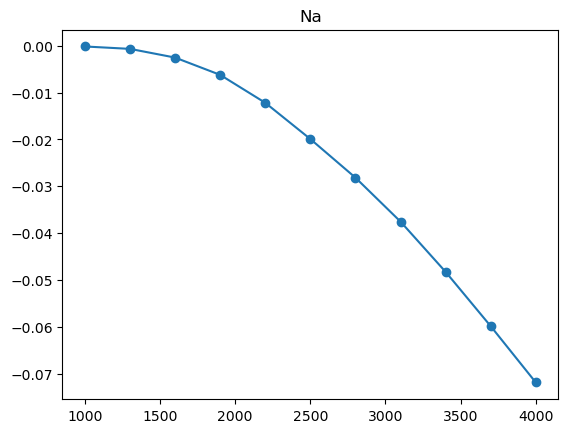

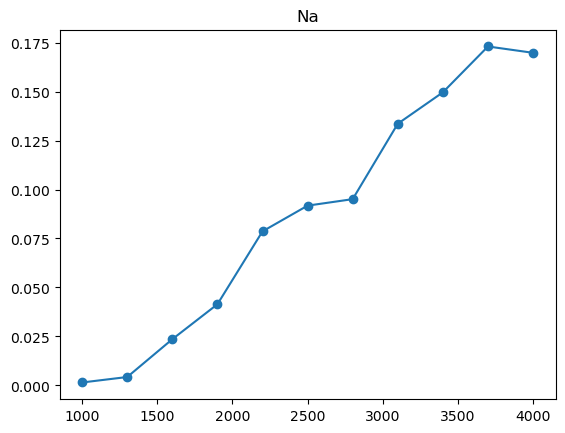

In [179]:
if len(Ts) == 1:                
    plt.figure(1)
    plt.plot(mus, phiTable[-1], '-o')
    plt.title(gs_name)
    # plt.show()
    plt.figure(2)
    plt.plot(mus, XTable[-1], '-o')
    plt.title(gs_name)
else:
    plt.figure(1)
    plt.plot(Ts, phiTable[:,0], '-o')
    plt.title(gs_name)
    # plt.show()
    plt.figure(2)
    plt.plot(Ts, XTable[:,0], '-o')
    plt.title(gs_name)

plt.show()

In [51]:
XTable[:,0]

array([1.])

In [175]:
savedMus = mus.copy()
savedTs = Ts.copy()
savedPhiTable = phiTable.copy()
savedXTable = XTable.copy()

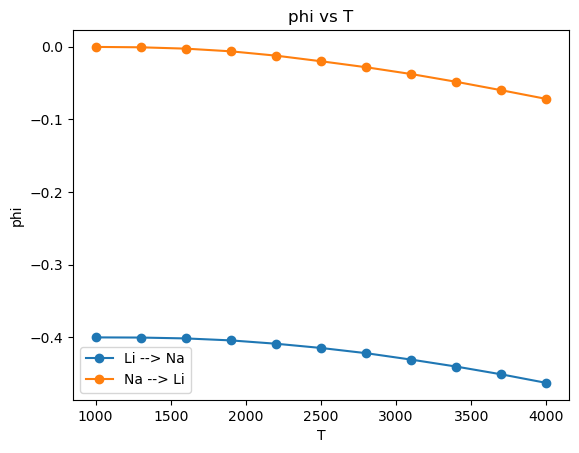

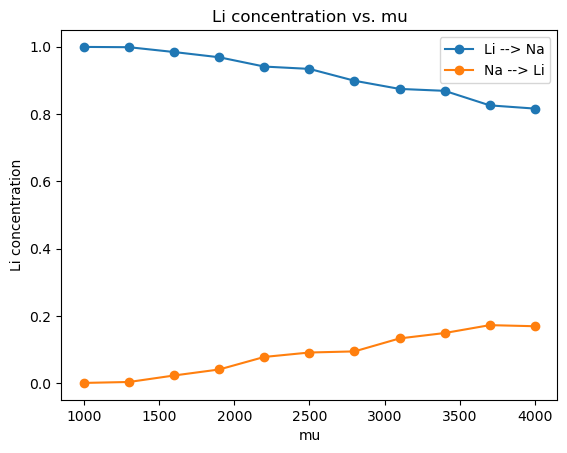

In [180]:
if len(Ts) == 1:                
    plt.figure(1)
    plt.plot(savedMus, savedPhiTable[-1], '-o')
    plt.plot(mus, phiTable[-1], '-o')
    plt.title(gs_name)
    # plt.show()
    plt.figure(2)
    plt.plot(savedMus, savedXTable[-1], '-o')
    plt.plot(mus, XTable[-1], '-o')
    plt.title(gs_name)
else:
    plt.figure(1)
    plt.plot(savedTs, savedPhiTable[:,0], '-o')
    plt.plot(Ts, phiTable[:,0], '-o')
    plt.title(gs_name)
    # plt.show()
    plt.figure(2)
    plt.plot(savedTs, savedXTable[:,0], '-o')
    plt.plot(Ts, XTable[:,0], '-o')
    plt.title(gs_name)

plt.figure(1)
plt.title("phi vs T")
plt.xlabel("T")
plt.ylabel("phi")
plt.legend(["Li --> Na", "Na --> Li"])
# plt.xlim([-0.25, 0.25])
# plt.ylim([-0.5, 0])
# plt.savefig('T_phi.png')

plt.figure(2)
plt.title("Li concentration vs. mu")
plt.xlabel("mu")
plt.ylabel("Li concentration")
plt.legend(["Li --> Na", "Na --> Li"])
# plt.xlim([-0.25, 0.25])
# plt.savefig('mu_x.png')
plt.show()